# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import datetime
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import AUC
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
%load_ext tensorboard
import keras_tuner as kt
from keras_tuner import HyperParameters, Tuner
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# !rm -rf ./logs/

# Mirrored Strategy

In [2]:
# Define the MirroredStrategy
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


# Loading Dataset

In [3]:
source_path = '.'
train_directory = os.path.join(source_path, 'CheXpert-v1.0/train')
validation_directory = os.path.join(source_path, 'CheXpert-v1.0/valid')
test_directory = os.path.join(source_path, 'CheXpert-v1.0/test')

print(f"There are {len(os.listdir(train_directory))}")
print(f"There are {len(os.listdir(validation_directory))}")
print(f"There are {len(os.listdir(test_directory))}")

There are 64540
There are 200
There are 500


In [4]:
# Load train and valid labels
train_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/train.csv'))
valid_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/valid.csv'))
test_df = pd.read_csv(os.path.join(source_path, 'CheXpert-v1.0/test.csv'))

# Creating DataFrames

In [5]:
train_df = train_df[['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion',
                     'No Finding','Enlarged Cardiomediastinum', 'Lung Opacity','Lung Lesion','Pneumonia',
                     'Pneumothorax', 'Pleural Other', 'Fracture','Support Devices']]
train_df = train_df.fillna(0)

In [6]:
# Counting number of uncertain findings in each pathology

print(f"Cardiomegaly -1: {len(train_df[train_df['Cardiomegaly'] == -1])}")
print(f"Edema -1: {len(train_df[train_df['Edema'] == -1])}")
print(f"Consolodation -1: {len(train_df[train_df['Consolidation'] == -1])}")
print(f"Atelectasis -1: {len(train_df[train_df['Atelectasis'] == -1])}")
print(f"Pleural -1: {len(train_df[train_df['Pleural Effusion'] == -1])}")

Cardiomegaly -1: 8087
Edema -1: 12984
Consolodation -1: 27742
Atelectasis -1: 33739
Pleural -1: 11628


In [7]:
# UIgnore - Ignore rows where there is at least one uncertain reading
mask = (train_df != -1.0).all(axis=1)

# Apply the mask to filter the DataFrame
train_df_filtered = train_df[mask]

# Keeping the uncertain labels
train_df_uncertain = train_df[mask == False]

In [8]:
valid_df = valid_df[['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion',
                     'No Finding','Enlarged Cardiomediastinum', 'Lung Opacity','Lung Lesion','Pneumonia',
                     'Pneumothorax', 'Pleural Other', 'Fracture','Support Devices']]

In [9]:
#Load image paths

train_image_paths = [source_path + '/' + path for path in train_df_filtered['Path']]
train_image_uncertain_paths = [source_path + '/' + path for path in train_df_uncertain['Path']]
valid_image_paths = [source_path + '/' + path for path in valid_df['Path']]
test_image_paths = [source_path + '/' + path for path in test_df['Path']]

In [10]:
test_df = test_df[['Path','Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion',
                     'No Finding','Enlarged Cardiomediastinum', 'Lung Opacity','Lung Lesion','Pneumonia',
                     'Pneumothorax', 'Pleural Other', 'Fracture','Support Devices']]

In [11]:
# Create TensorFlow tensors from image paths
train_image_paths = tf.constant(train_image_paths)
train_image_uncertain_paths = tf.constant(train_image_uncertain_paths)
valid_image_paths = tf.constant(valid_image_paths)
test_image_paths = tf.constant(test_image_paths)

In [12]:
print(len(train_image_paths))
print(len(train_image_uncertain_paths))
print(len(valid_image_paths))
print(len(test_image_paths))

138358
85056
234
668


In [13]:
# Dropping path as no longer required

train_df = train_df_filtered.drop(['Path'], axis=1)
train_df_uncertain = train_df_uncertain.drop(['Path'], axis=1)
valid_df = valid_df.drop(['Path'], axis=1)
test_df = test_df.drop(['Path'], axis=1)

In [14]:
# Convert to array

train_labels = np.array(train_df)
train_labels_uncertain = np.array(train_df_uncertain)
valid_labels = np.array(valid_df)
test_labels = np.array(test_df)

In [15]:
print(train_labels.shape)
print(train_labels_uncertain.shape)
print(valid_labels.shape)
print(test_labels.shape)

(138358, 14)
(85056, 14)
(234, 14)
(668, 14)


# Load and Resize Image

In [16]:
from tqdm import tqdm
from keras.preprocessing import image

#training images preprocessing
SIZE = 320

# Define a custom preprocessing function
def preprocess_image(image_path, label):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image from bytes to a tensor
    image = tf.image.decode_jpeg(image, channels=3)
#     # Resize the image to a fixed size
#     image = tf.image.resize(image, [SIZE, SIZE])
    # Normalize pixel values to be in the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Prepare the data pipeline by setting batch size & buffer size using tf.data 

In [17]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_image_paths, valid_labels))
train_ds_uncertain = tf.data.Dataset.from_tensor_slices((train_image_uncertain_paths, train_labels_uncertain))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

In [18]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing function to the datasets
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
valid_ds = valid_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds_uncertain = train_ds_uncertain.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# Visualize Sample Image

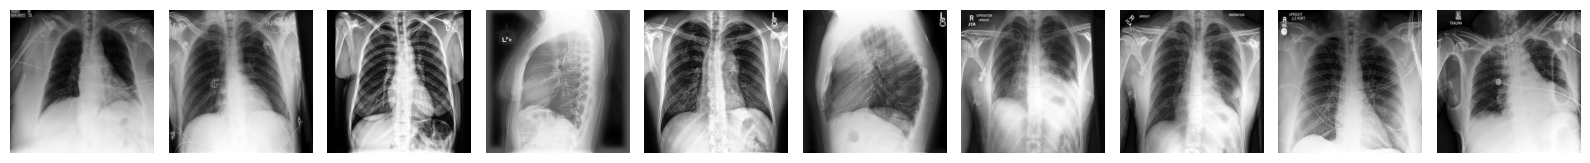

In [19]:
# Plot a sample of 10 original images
fig, axes = plt.subplots(1, 10, figsize=(16, 15))  # Adjust the figsize as needed
axes = axes.flatten()

for i, (image, label) in enumerate(train_ds.take(10)):
    ax = axes[i]
    ax.imshow(image.numpy())  # Select the first image from the batch
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Augementation

In [20]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(
        height_factor=(-0.05, -0.15),
        width_factor=(-0.05, -0.15)),
    #layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
])

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def prepare(ds, shuffle=False, augment=False):
    # If a shuffle buffer size is provided, shuffle the data with the specified buffer size
    if shuffle_buffer_size:
        ds = ds.shuffle(10000)
    
    ds = ds.batch(batch_size)

    # Removing cache call here if the dataset is too large to fit into memory
    # If you still want to use cache, consider using it before the shuffle and batch for efficiency
    # ds = ds.cache()

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

# Set a large shuffle buffer size for better randomization
shuffle_buffer_size = 10000

In [ ]:
# def prepare(ds, shuffle=False, augment=False):
#     if shuffle:
#         ds = ds.shuffle(1000)

#     ds = ds.batch(batch_size)
#     ds = ds.cache()

#     if augment:
#         ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
#                     num_parallel_calls=AUTOTUNE)

#     return ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
train_ds_uncertain = prepare(train_ds_uncertain, shuffle=True, augment=True)
valid_ds = prepare(valid_ds)
test_ds = prepare(test_ds)

# Visualize Augmented Image

In [ ]:
# Define a function to plot sample images
def plot_sample_images(dataset, num_samples=10):
    # Create an iterator for the dataset
    iterator = iter(dataset)

    # Get the next batch of images and labels
    sample_images, sample_labels = next(iterator)

    # Plot the sample images
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 15))
    axes = axes.flatten()

    for i in range(num_samples):
        img = sample_images[i]
        ax = axes[i]
        ax.imshow(img.numpy())  # Convert TensorFlow tensor to NumPy array for plotting
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()

# Visualize sample images from the training dataset
plot_sample_images(train_ds, num_samples=10)

# Build the Model

In [23]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications.densenet import DenseNet121

def create_model():
    with mirrored_strategy.scope():
        model = tf.keras.models.Sequential()
        pre_trained_model = tf.keras.applications.densenet.DenseNet121(
            include_top=False,
            weights='imagenet',
            input_shape=(320, 320, 3)
        )

        for layer in pre_trained_model.layers:
            layer.trainable = False

        model.add(pre_trained_model)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(2048, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(tf.keras.layers.Dense(units=14, activation='sigmoid'))

        #     model.add(tf.keras.layers.Flatten())
        #     model.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
        #     model.add(tf.keras.layers.Dense(units = 5, activation = 'sigmoid'))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
                      loss='binary_crossentropy',
                      metrics=['binary_accuracy', tf.keras.metrics.AUC(multi_label=True, num_labels=14)])

        return model

# Train the Model

In [27]:
import time

def create_callbacks(run_num):
    log_dir = "logs/fit/uself_dist" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # Modify the checkpoint_dir to include the run number.
    checkpoint_dir = f"logs/fit/uself_dist/run_{run_num}"

    # Ensure the directory exists
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    # SaveCheckpointCallback class definition
    class SaveCheckpointCallback(tf.keras.callbacks.Callback):
        def __init__(self, checkpoint_dir, save_interval):
            super(SaveCheckpointCallback, self).__init__()
            self.checkpoint_dir = checkpoint_dir
            self.save_interval = save_interval
            self.iteration = 0

        def on_batch_end(self, batch, logs=None):
            self.iteration += 1
            if self.iteration % self.save_interval == 0:
                model_checkpoint = os.path.join(self.checkpoint_dir, f"model_checkpoint_{self.iteration}.h5")
                self.model.save(model_checkpoint)
                print(f"Saved checkpoint at iteration {self.iteration} to {model_checkpoint}")

    save_interval = 4800 
    checkpoint_callback = SaveCheckpointCallback(checkpoint_dir, save_interval)
    
    return [checkpoint_callback, tensorboard_callback]

In [28]:
trained_models = []

def train(num_runs, train_ds, valid_ds):

    for run in range(num_runs):
        print(f"Run {run + 1} of {num_runs}")

        # Clear previous session to ensure a fresh start for each run
        tf.keras.backend.clear_session()

        model = create_model()
        callbacks = create_callbacks(run+1)

        start = time.time()
        history = model.fit(train_ds, epochs=2, validation_data=valid_ds, batch_size=batch_size, callbacks=callbacks, verbose=2)
        print("Total time for run", run + 1, ": ", time.time() - start, "seconds")
        
        trained_models.append(model)

    return trained_models


In [29]:
# Define the number of runs
num_runs = 1
training = train(num_runs, train_ds, valid_ds)

Run 1 of 1
Epoch 1/2
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved checkpoint at iteration 4800 to logs/fit/uself_dist/run_1/model_checkpoint_4800.h5
8648/8648 - 344s - loss: 0.4134 - binary_accuracy: 0.8155 - auc: 0.5935 - val_loss: 0.4781 - val_binary_accuracy: 0.8117 - val_auc: 0.6733 - 344s/epoch - 40ms/step
Epoch 2/2
Saved checkpoint at iteration 9600 to logs/fit/uself_dist/run_1/model_checkpoint_9600.h5
Saved checkpoint at iteration 14400 to logs/fit/uself_dist/run_1/model_checkpoint_14400.h5
8648/8648 - 304s - loss: 0.3554 - binary_accuracy: 0.8491 - auc: 0.6297 - val_loss: 0.4442 - val_binary_accuracy: 0.8141 - val_auc: 0.6576 - 304s/epoch - 35ms/step
Total time for run 1 :  654.5224268436432 seconds


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
%tensorboard --logdir logs --port 8885

# Evaluate the Model with Uncertain Labels

In [30]:
all_predictions_uncertain = []
all_actual_labels_uncertain = []

# Iterate over the dataset and collect predictions for individual images
for model in trained_models:
    predictions = model.predict(train_ds_uncertain)  # Get predictions for the current batch of images
    all_predictions_uncertain.extend(predictions)

5316/5316 [==============================] - 154s 27ms/step


In [31]:
all_predictions_uncertain = np.array(all_predictions_uncertain)
print(all_predictions_uncertain.shape)
print(train_labels_uncertain.shape)

(85056, 14)
(85056, 14)


# Re-labeling uncertain labels

In [32]:
# Re-labeling each of the uncertainty labels without replacing instances of 0 and 1

mask = train_labels_uncertain == -1
print(mask.shape)
new_prediction = np.where(mask,all_predictions_uncertain,train_labels_uncertain)

print("Actual vs. Prediction for the first 10 images:")
for i in range(2):
    prediction_2 = new_prediction[i]
    actual_2= np.array(train_labels_uncertain[i]).astype(int)
    print(f"Actual Labels: {actual_2}")
    print(f"New Predictions  : {prediction_2}")

(85056, 14)
Actual vs. Prediction for the first 10 images:
Actual Labels: [-1 -1 -1 -1 -1  0  0  1  0  0  0  0  1  0]
New Predictions  : [0.09239328 0.08843666 0.02779554 0.12170456 0.10346863 0.
 0.         1.         0.         0.         0.         0.
 1.         0.        ]
Actual Labels: [ 0  0 -1  0  0  0  0  1  0  0  0  0  1  0]
New Predictions  : [0.         0.         0.06471738 0.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.        ]


# Retraining the Model including the re-labeled data

In [33]:
# Combine the image paths
combined_paths = []
combined_paths.extend(train_image_paths)
combined_paths.extend(train_image_uncertain_paths)

combined_labels = []
combined_labels.extend(train_labels)
combined_labels.extend(new_prediction)
combined_labels = np.array(combined_labels)

In [34]:
print(len(combined_paths))
print(len(combined_labels))

223414
223414


In [35]:
# Create a tf.data.Dataset
new_train_ds = tf.data.Dataset.from_tensor_slices((combined_paths, combined_labels))
new_train_ds = new_train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
new_train_ds = prepare(new_train_ds, shuffle=True, augment=True)

# Hyperparameter Tuning

In [36]:
def create_model(hp):
    with mirrored_strategy.scope():
        model = tf.keras.models.Sequential()
        pre_trained_model = tf.keras.applications.densenet.DenseNet121(
            include_top=False,
            weights='imagenet',
            input_shape=(320, 320, 3)
        )

        model.add(pre_trained_model)
        model.add(GlobalAveragePooling2D(input_shape=(1024, 1, 1)))

        # Use hyperparameters to define the units for the first Dense layer
        dense1_units = hp.Int('dense_1_units', min_value=512, max_value=2048, step=512)
        model.add(Dense(dense1_units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

        # Use hyperparameters to define the units for the second Dense layer
        dense2_units = hp.Int('dense_2_units', min_value=256, max_value=1024, step=256)
        model.add(Dense(dense2_units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

        # The third Dense layer is the output layer with fixed units
        model.add(tf.keras.layers.Dense(units=14, activation='sigmoid'))

        # Define hyperparameters for the learning rate
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        
        model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.AUC(multi_label=True, num_labels=14)])
        
        return model

In [37]:
tuner = kt.Hyperband(
    create_model,
    objective=Objective('val_auc', direction ="max"),
    max_epochs=4,
    factor=5,
    hyperband_iterations=1,  # number of times to iterate over the hyperband algorithm
    directory='kt_hyperband',
    project_name='uself_tuning'
)

In [38]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [39]:
tuner.search(train_ds, epochs=4, validation_data=(test_ds), callbacks=[stop_early], verbose = 2)

Trial 2 Complete [00h 51m 34s]
val_auc: 0.7537784576416016

Best val_auc So Far: 0.7537784576416016
Total elapsed time: 01h 42m 13s


In [40]:
best_hps = tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. Here are the optimal values:
Dense1_units: {best_hps.get('dense_1_units')}
Dense2_units: {best_hps.get('dense_2_units')}
Dropout1: {best_hps.get('dropout_1')}
Dropout2: {best_hps.get('dropout_2')}
Learning rate: {best_hps.get('learning_rate')}
""")


The hyperparameter search is complete. Here are the optimal values:
Dense1_units: 2048
Dense2_units: 256
Dropout1: 0.30000000000000004
Dropout2: 0.4
Learning rate: 6.425128602850992e-05



In [41]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.
cnn = tuner.hypermodel.build(best_hps)
history = cnn.fit(train_ds, epochs=10, validation_data=(valid_ds), verbose = 2)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 372 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 372 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
8648/8648 - 1123s - loss: 0.4883 - binary_accuracy: 0.7726 - auc_1: 0.5691 - val_loss: 0.5090 - val_binary_accuracy: 0.8095 - val_auc_1: 0.6347 - 1123s/epoch - 130ms/step
Epoch 2/10
8648/8648 - 938s - loss: 0.3613 - binary_accuracy: 0.8487 - auc_1: 0.6216 - val_loss: 0.4602 - val_binary_accuracy: 0.8193 - val_auc_1: 0.6450 - 938s/epoch - 108ms/step
Epoch 3/10
8648/8648 - 966s - loss: 0.3424 - binary_accuracy: 0.8567 - auc_1: 0.6607 - val_loss: 0.4910 - val_binary_accuracy: 0.7952 - val_auc_1: 0.6384 - 966s/epoch - 112ms/step
Epoch 4/10
8648/8648 - 950s - loss: 0.3314 - binary_accuracy: 0.8619 - auc_1: 0.6872 - val_loss: 0.4558 - val_binary_accuracy: 0.8138 

In [42]:
val_auc_per_epoch = history.history['val_auc_1']
best_epoch = val_auc_per_epoch.index(max(val_auc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 7


# Retrain the Model 3x

In [43]:
trained_models = []

def retrain(num_runs, train_ds, valid_ds, best_epoch):

    for run in range(num_runs):
        print(f"Run {run + 1} of {num_runs}")

        # Clear previous session to ensure a fresh start for each run
        tf.keras.backend.clear_session()
        
        # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
        # Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.
        model = tuner.hypermodel.build(best_hps)
        callbacks = create_callbacks(run+1)

        start = time.time()
        history = model.fit(train_ds, epochs=best_epoch, validation_data=valid_ds, batch_size=batch_size, callbacks=callbacks, verbose=2)
        print("Total time for run", run + 1, ": ", time.time() - start, "seconds")
        
        trained_models.append(model)

    return trained_models

# Define the number of runs
num_runs2 = 3
training = retrain(num_runs2, new_train_ds, valid_ds,best_epoch)

Run 1 of 3
Epoch 1/7
INFO:tensorflow:Collective all_reduce tensors: 372 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 372 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
Saved checkpoint at iteration 4800 to logs/fit/uself_dist/run_1/model_checkpoint_4800.h5
Saved checkpoint at iteration 9600 to logs/fit/uself_dist/run_1/model_checkpoint_9600.h5
13964/13964 - 1731s - loss: 0.4353 - binary_accuracy: 0.7667 - auc: 0.5527 - val_loss: 0.4968 - val_binary_accuracy: 0.8062 - val_auc: 0.6016 - 1731s/epoch - 124ms/step
Epoch 2/7
Saved checkpoint at iteration 14400 to logs/fit/uself_dist/run_1/model_checkpoint_14400.h5
Saved checkpoint at iteration 19200 to logs/fit/uself_dist/run_1/model_checkpoint_19200.h5
Saved checkpoint at iteration 24000 to logs/fit/uself_dist/run_1/model_checkpoint_24000.h5
13964/13964 - 1564s - los

In [ ]:
# # Define the number of runs
# num_runs2 = 3
# training = train(num_runs2, train_ds, valid_ds)

In [ ]:
%tensorboard --logdir logs --port 8885

# Model Evaluate on Checkpoint

In [44]:
print(len(trained_models))

3


In [47]:
# Initialize a list to store checkpoint paths for each run
checkpoint_paths_list = []

for run in range(num_runs2):
    checkpoint_paths = []  # Store checkpoint paths for the current model

    # Collect checkpoint paths
    for iteration in range(4800, 96001, 4800):  # Modify this range according to your save_interval and number of checkpoints
        checkpoint_path = f"logs/fit/uself_dist/run_{run + 1}/model_checkpoint_{iteration}.h5"
        checkpoint_paths.append(checkpoint_path)

    checkpoint_paths_list.append(checkpoint_paths)

In [50]:
from sklearn.metrics import roc_auc_score

all_valid_images = []
all_valid_labels = []

for images, labels in valid_ds:
    all_valid_images.append(images.numpy())
    all_valid_labels.append(labels.numpy())

# Concatenate all images and labels into two large numpy arrays
all_valid_images = np.concatenate(all_valid_images, axis=0)
all_valid_labels = np.concatenate(all_valid_labels, axis=0)
print(f"all_valid_images shape: {all_valid_images.shape}")
print(f"all_valid_labels shape: {all_valid_labels.shape}")

# Initialize a list to store predictions for each checkpoint
all_predictions = []

# Iterate through the collected checkpoint paths and corresponding trained model
for model, checkpoint_paths in zip(trained_models, checkpoint_paths_list):
    predictions = []  # Store predictions for the current run

    # Load each checkpoint and predict on the validation set
    for checkpoint_path in checkpoint_paths:
        model.load_weights(checkpoint_path)

        # Predict on the validation set
        checkpoint_predictions = model.predict(all_valid_images)
        predictions.append(checkpoint_predictions)

    all_predictions.append(predictions)
all_predictions = np.array(all_predictions)

print(f"all pred shape: {all_predictions.shape}")

average_auroc_list = []
num_pathologies = 5
iteration_auroc = [] # List of all AUROCs per pathology

for checkpoint_predictions in all_predictions:

    for checkpoint_index, checkpoint_prediction in enumerate(checkpoint_predictions):
        checkpoint_auroc_scores = []  # Store AUROC scores for the current model

        for pathology_index in range(num_pathologies):
            true_labels = all_valid_labels[:, pathology_index]
            auroc = roc_auc_score(true_labels, checkpoint_prediction[:, pathology_index])
            checkpoint_auroc_scores.append(auroc)

        iteration_auroc.append(checkpoint_auroc_scores)

# Convert iteration_auroc to array
iteration_auroc = np.array(iteration_auroc)

print(f"iteration_auroc_shape: {iteration_auroc.shape}")

# Calculate the average AUROC across 5 pathologies
average_auroc = np.mean(iteration_auroc, axis = 1)

# Calculate the indices that would sort the average AUROC list in descending order
sorted_indices = np.argsort(average_auroc)[::-1]

# Get the top 20 indices
top_indices = sorted_indices[:20]

# Initialize a list to store the corresponding checkpoint_auroc_scores
best_checkpoint_auroc_scores = []

# Extract the checkpoint_auroc_scores for the best 20 averages
for index in top_indices:
    best_checkpoint_auroc_scores.append(iteration_auroc[index])

best_checkpoint_auroc_scores = np.array(best_checkpoint_auroc_scores)

pathology_names = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']
# Compute AUROC, Standard Deviation, and Confidence Intervals
auroc_pathology = np.mean(best_checkpoint_auroc_scores, axis=0)
std_dev_pathology = np.std(best_checkpoint_auroc_scores, axis=0)
confidence_intervals = [(auroc - 1.96 * std, auroc + 1.96 * std) for auroc, std in zip(auroc_pathology, std_dev_pathology)]

# Header
print(f"{'Pathology':<15} {'Average AUROC':<15} {'Standard Error':<17} {'95% Confidence Interval'}")

# Separator
print('-' * 65)

# Table content
for i, pathology in enumerate(pathology_names):
    standard_error = std_dev_pathology[i] / np.sqrt(len(best_checkpoint_auroc_scores))
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"{pathology:<15} {auroc_pathology[i]:<15.4f} {standard_error:<17.4f} ({lower_bound:.4f}, {upper_bound:.4f})")

# Overall AUROC
overall_ave = np.mean(average_auroc[top_indices])
print(f"\nOverall average AUROC (from top 3 models/checkpoints): {overall_ave:.4f}")


all_valid_images shape: (234, 320, 320, 3)
all_valid_labels shape: (234, 14)
8/8 [==============================] - 1s 32ms/step
all pred shape: (3, 20, 234, 14)
iteration_auroc_shape: (60, 5)
Pathology       Average AUROC   Standard Error    95% Confidence Interval
-----------------------------------------------------------------
Atelectasis     0.7731          0.0060            (0.7208, 0.8253)
Cardiomegaly    0.7229          0.0067            (0.6639, 0.7819)
Consolidation   0.8800          0.0059            (0.8284, 0.9315)
Edema           0.8777          0.0043            (0.8400, 0.9155)
Pleural Effusion 0.8887          0.0037            (0.8558, 0.9215)

Overall average AUROC (from top 3 models/checkpoints): 0.8285


In [52]:
# Getting test images and labels:
all_test_images = []
all_test_labels = []

for images, labels in test_ds:
    all_test_images.append(images.numpy())
    all_test_labels.append(labels.numpy())

# Concatenate all images and labels into two large numpy arrays
all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)
print(f"all_test_images shape: {all_test_images.shape}")
print(f"all_test_labels shape: {all_test_labels.shape}")

# Calculate the number of checkpoints per model
num_checkpoints_per_model = len(checkpoint_paths_list[0])  # or use all_predictions.shape[1] if available

# Determine the best model and checkpoint indices based on the best_model_index
best_model_index = top_indices[0] // num_checkpoints_per_model
best_checkpoint_index = top_indices[0] % num_checkpoints_per_model

# Reference the predictions of the best model and checkpoint
best_model_predictions = all_predictions[best_model_index, best_checkpoint_index]

# Load the best checkpoint weights into the corresponding model
best_model = trained_models[best_model_index]
best_checkpoint_path = checkpoint_paths_list[best_model_index][best_checkpoint_index]
best_model.load_weights(best_checkpoint_path)

# Predict on the test set using the best model
test_predictions = best_model.predict(all_test_images)
print(f"test_predictions shape: {test_predictions.shape}")

pathology_names = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion']  # 

# Directory where the figures will be saved
save_dir = "test_performance/uself_ht"
os.makedirs(save_dir, exist_ok=True)

# 2. Calculate and Plot ROC for each pathology
for i in range(num_pathologies):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    auc = roc_auc_score(test_labels[:, i], test_predictions[:, i])
    plt.figure()
    plt.plot(fpr, tpr, label=f"{pathology_names[i]} (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {pathology_names[i]}")
    plt.legend(loc="lower right")
    plt.tight_layout()

    # Save ROC curve
    roc_filename = f"{pathology_names[i]}_auroc.png"
    plt.savefig(os.path.join(save_dir, roc_filename))
    plt.close()

# 2. Calculate and Plot PR curve for each pathology
for i in range(num_pathologies):
    precision, recall, _ = precision_recall_curve(test_labels[:, i], test_predictions[:, i])
    average_precision = average_precision_score(test_labels[:, i], test_predictions[:, i])
    plt.figure()
    plt.plot(recall, precision, label=f"{pathology_names[i]} (AP = {average_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {pathology_names[i]}")
    plt.legend(loc="upper right")
    plt.tight_layout()

    # Save PR curve
    pr_filename = f"{pathology_names[i]}_pr.png"
    plt.savefig(os.path.join(save_dir, pr_filename))
    plt.close()


all_test_images shape: (668, 320, 320, 3)
all_test_labels shape: (668, 14)
21/21 [==============================] - 1s 36ms/step
test_predictions shape: (668, 14)


## Explaining the Prediction

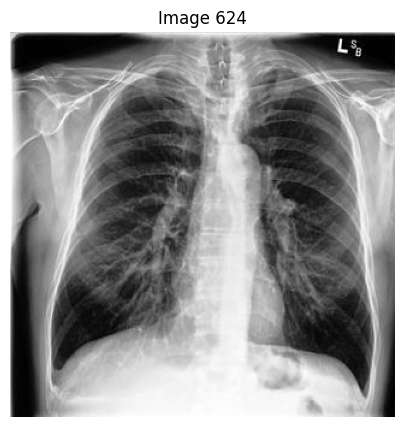

In [53]:
import random

index = random.randint(0,all_test_images.shape[0])
image = all_test_images[index]

plt.figure(figsize=(5,5))
plt.imshow(image, cmap='gray')
plt.title(f"Image {index}")
plt.axis('off')  # Hide the axis
plt.show()

Top 5 Predictions:
Pathology                 Probability
Lung Opacity              0.58
Pleural Effusion          0.31
Support Devices           0.19
Atelectasis               0.15
Lung Lesion               0.08


100%|██████████| 1000/1000 [00:37<00:00, 26.94it/s]


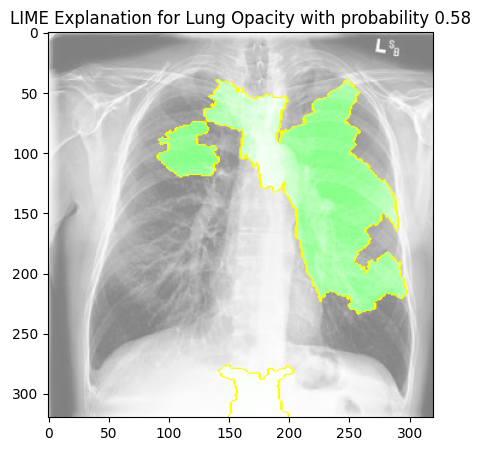

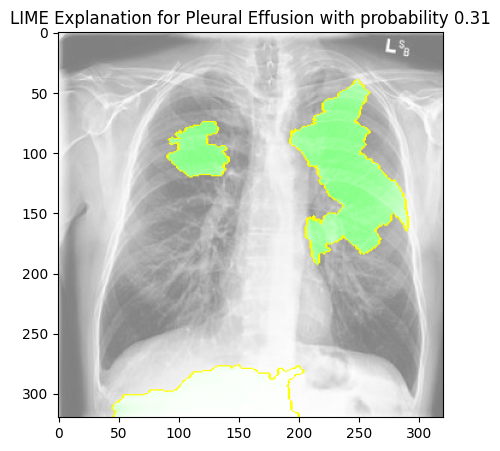

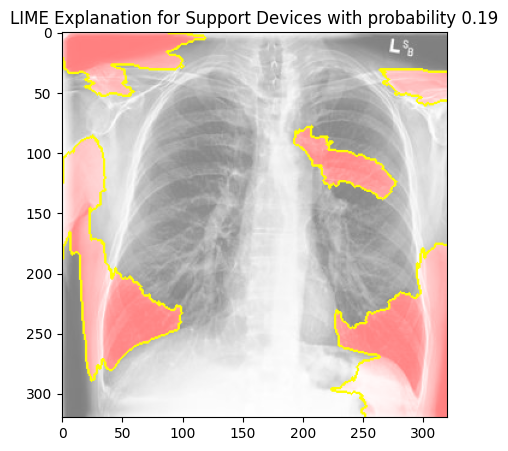

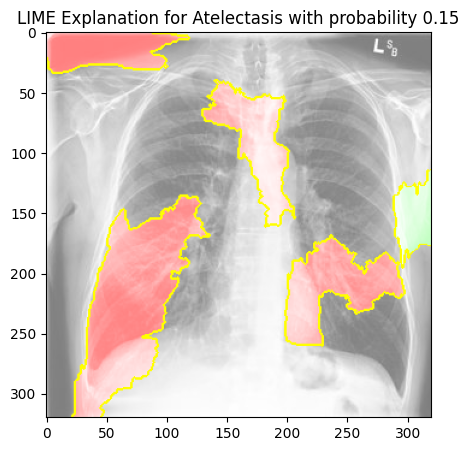

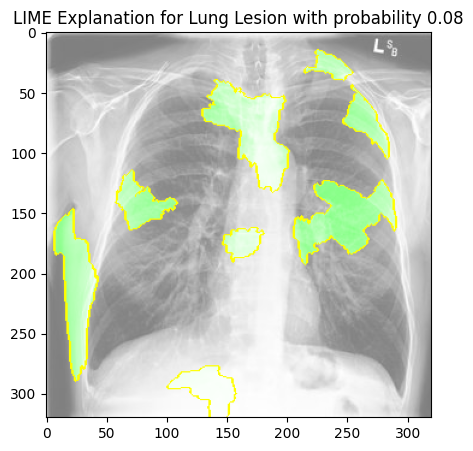

In [54]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Instantiate the LIME image explainer
explainer = lime_image.LimeImageExplainer()

def model_predict(images):
    predictions = best_model.predict(images, verbose=0)
    return predictions

# Define your pathology list
all_pathology = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Pleural Effusion',
                 'No Finding','Enlarged Cardiomediastinum', 'Lung Opacity','Lung Lesion','Pneumonia',
                 'Pneumothorax', 'Pleural Other', 'Fracture','Support Devices']

# Get the prediction for an individual image (assuming image is preprocessed accordingly)
predictions = model_predict(np.array([image]))[0]  # Get the prediction for the first image

# Pair each probability with the corresponding pathology and sort them
probabilities_and_pathologies = [(p, all_pathology[i]) for i, p in enumerate(predictions)]
top_5_predictions = sorted(probabilities_and_pathologies, key=lambda x: x[0], reverse=True)[:5]

# Print the top 5 predictions
print("Top 5 Predictions:")
print("{:<25} {}".format("Pathology", "Probability"))
for probability, pathology in top_5_predictions:
    print("{:<25} {:.2f}".format(pathology, probability))

# Explain instance with LIME
explanation = explainer.explain_instance(
    image,
    model_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000  # Number of samples to use for LIME approximation
)

# Visualize the explanation for each of the top labels
for probability, pathology in top_5_predictions:
    # Find the index of the pathology in all_pathology list which corresponds to the model's output
    model_label_index = all_pathology.index(pathology)
    
    # Check if this label index is in explanation.top_labels
    if model_label_index in explanation.top_labels:
        temp, mask = explanation.get_image_and_mask(model_label_index,
                                                    positive_only=False,
                                                    num_features=10,
                                                    hide_rest=False)
        plt.figure(figsize=(5, 5))
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        plt.title(f"LIME Explanation for {pathology} with probability {probability:.2f}")
        plt.show()
    else:
        print(f"No LIME explanation for {pathology}")